#  Классификация текстов с использованием эмбеддингов слов.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/text/stable/vocab.html
* https://pytorch.org/text/stable/transforms.html
* https://rusvectores.org/
* https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
* https://github.com/natasha/navec
* https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
* https://torchmetrics.readthedocs.io/en/stable/

## Задачи для совместного разбора

1\. Реализуйте модель для классификации текстов с использованием слоя `nn.Embedding`. Заморозьте веса слоя эмбеддингов.

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
X = th.randint(0, 1000, size=(16, 20)).long()
y = th.LongTensor([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,1 ,1])

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.emb = nn.Embedding(
        1000,
        100
    )
    self.fc = nn.Linear(100, 2)

  def forward(self, X):
    e = self.emb(X) # batch x len_seq x emb_dim
    # преобразуем эмб токенов
    e = e.mean(dim=1) # batch x emb_dim
    out = self.fc(e)
    return out # batch x 2

In [ ]:
model = Net()
y_pred = model(X)
y_pred.shape

torch.Size([16, 2])

In [ ]:
model.emb.weight.requires_grad_(False)
model.emb.weight.requires_grad

False

2\. Используя `torchmetrics`, рассчитайте значение accuracy по эпохам с использованием мини-пакетного градиентого спуска.

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.3 MB/s eta 0:00:00


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torchmetrics as M

In [ ]:
dset = TensorDataset(X, y)
loader = DataLoader(dset, batch_size=4)

n_epoch = 5
lr = 0.001

model = Net()
crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(n_epoch):
  pred, true = [], []
  running_correct, running_count = 0, 0
  running_acc = 0
  running_steps = 0

  acc_m = M.Accuracy(task='binary')

  for step, X_b, y_b in enumerate(loader):
    y_pred = model(X_b)
    loss = crit(y_pred, y_b)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #v1
    pred.extend(list(y_pred))
    true.extend(list(y_b))
    #v2
    running_correct += (y_pred.argmax(dim=1) == y_b).sum()
    running_count += len(y_b)
    #v3
    acc = (y_pred.argmax(dim=1) == y_b).float().mean()
    running_acc += acc
    running_steps += 1
    #v4
    acc_m.update(y_pred.argmax(dim=1), y_b)

    print(f'{epoch=} {step=} {acc.item()=}')

  pred = th.tensor(pred)
  true = th.tensor(true)
  acc_epoch = (pred.argmax(dim=1) == true).float().mean()
  acc_epoch_m = acc_m.compute()

## Задачи для самостоятельного решения

In [ ]:
!pip install torchmetrics

In [3]:
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
import torchmetrics as M
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
import re
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
sw = stopwords.words('russian')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!wget "https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/UD7tIq5NJa1A0g"

<p class="task" id="1"></p>

1\. Считайте файл `lenta_news.csv` и разбейте на обучающую и тестовую выборку. Выполните предобработку текста и создайте Vocab на основе обучающей выборки (токен - слово). Выведите на экран количество токенов в полученном словаре.

- [ ] Проверено на семинаре

In [5]:
df = pd.read_csv('UD7tIq5NJa1A0g')
df.head()

,title,text,topic
0,МВД создало бюро по борьбе с отмыванием денег,В МВД России создано оперативно-розыскное бюро...,Экономика
1,Правительство не будет занимать деньги у ЦБ,Правительство не будет прибегать к заимствован...,Экономика
2,"ВВС США заказали 60 ""Боингов"" для вторжения в ...",Компания Boeing получит пятилетний контракт на...,Экономика
3,Правительственная комиссия не дала ExxonMobil ...,Результаты конкурса на право освоения месторож...,Экономика
4,Неимущим для получения пособия придется расста...,В доходах малоимущих россиян будут учитываться...,Экономика


In [6]:
def processing(text):
  tokenizer = RegexpTokenizer(r'\w+')
  res = []
  tokens = tokenizer.tokenize(re.sub(r'[^А-Яа-я ]', ' ', text))
  for tok in tokens:
    if tok not in sw:
      res.append(tok.lower())
  return [res]

In [7]:
corpus = df['text'].apply(processing).sum()

In [8]:
train, test = train_test_split(list(zip(corpus, df['topic'])), test_size=0.2, random_state=42)
len(train), len(test)

(19159, 4790)

In [13]:
vocab = build_vocab_from_iterator(list(map(lambda x: x[0], train)), specials=['<PAD>', '<UNK>'])
vocab.set_default_index(vocab['<UNK>'])

In [ ]:
len(vocab)

165559

<p class="task" id="2"></p>


2\. Создайте класс `NewsDataset`. Реализуйте метод `__getitem__` таким образом, чтобы он возвращал набор индексов токенов для текста новости (или новостей, если используются срезы) и метки классов для этих новостей. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины (подходящее значение определите сами). Закодируйте целыми числами категории новостей. Создайте два объекта класса `NewsDataset` (для обучающей и тестовой выборки).

Выведите на экран результат выполнения `train_dataset[0]` и `train_dataset[:3]`

- [ ] Проверено на семинаре

In [12]:
class NewsDataset:
  def __init__(self, data):
    self.data = list(map(lambda x: x[0], data))
    self.le = LabelEncoder()
    self.labels = list(map(lambda x: x[1], data))
    self.le.fit(self.labels)
    self.transforms = T.Sequential(
        T.ToTensor(0),
        T.PadTransform(max_length=900, pad_value=0)
    )

  def __getitem__(self, idx):
    if isinstance(idx, slice):
      res = []
      for text in self.data[idx]:
        res.append(vocab.lookup_indices(text))
      return self.transforms(res), self.le.transform(self.labels[idx])
    else:
      return self.transforms(vocab.lookup_indices(self.data[idx])), self.le.transform([self.labels[idx]])

  def __len__(self):
    return len(self.data)

In [18]:
train_dataset = NewsDataset(train)
test_dataset = NewsDataset(test)
train_dataset[0], train_dataset[:3]

((tensor([   920,   2427,  25378,   3537,  31437,   2075,  69174,  47940,   5249,
             140,   1032,   1968,   5339,  54884,   2076,    620,      6,    665,
            1641,    974,  11096,   4618,    918,   1258,   7591,   1155,    958,
           82615,   3657,    763,   1121,  70523,  39418,     94,  44619,   9420,
             136,    713,    502,   7591,   2075,  47940, 101748,     55,    650,
             315,     96,      3,   4059,  67233,   2075,  47940,   9716,     10,
          155443,  11486,    665,  15919,   8565,    828,    303,  19301,   9956,
             342,    175,   2922,    842,  13373,   2111,  13009,  12197,   3200,
           15594,   2306,   7059,  18854,   1018, 153887,      2,    229,    433,
            1005,   5561,  68160,   8712,    506,  50105,   3258,  29207,    713,
           11240,  33053,   1220,  12513,   3151,    299,   9715,  46897,  30687,
             300,  15198,   3537,  31437,     65,  64955,   4209,   2463,  40546,
          104048

<p class="task" id="3"></p>

3\. Реализуйте модель, которая получает на вход батч новостей (в виде индексов токенов), пропускает его через слой `nn.Embedding` (матрица эмбеддингов инициализируется случайным образом), после чего передает полученные эмбеддинги части-классификатору (который состоит из некоторого количества полносвязных слоев). Для получения эмбеддинга для предложения на основе эмбеддингов слов воспользуйтесь любой функцией агрегации, сохраняющей размерности векторов (сумма, усреднение и т.д.).

Решите задачу классификации новостей. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики f1 на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран отчет по классификации на обучающем и тестовом множестве.

- [ ] Проверено на семинаре

In [33]:
import warnings

warnings.filterwarnings("ignore", message="The inner type of a container is lost when calling torch.jit.isinstance in eager mode.")

In [22]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.emb = nn.Embedding(num_embeddings=len(vocab), embedding_dim=300)
    self.fc1 = nn.Linear(in_features=300, out_features=16)
    self.fc2 = nn.Linear(in_features=16, out_features=len(train_dataset.le.classes_))
    self.relu = nn.ReLU()

  def forward(self, X):
    e = self.emb(X)
    e = e.mean(dim=1)
    out = self.fc1(e)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [23]:
train_loader = DataLoader(train_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [24]:
%%time
n_epoch = 15
lr = 0.1
model = Model()
optimizer = optim.Adam(model.parameters(), lr=lr)
model.emb.weight.requires_grad_(False)
crit = nn.CrossEntropyLoss()
f1 = M.F1Score(task='multiclass', num_classes=len(train_dataset.le.classes_))
loss_curve = []
f1_values_train = []
f1_values_test = []

for epoch in range(n_epoch):
  f1_batch = []
  for X_b, y_b in train_loader:
    out = model(X_b)
    loss = crit(out, th.flatten(y_b))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    f1.update(out.argmax(dim=1), y_b.flatten())
    f1_batch.append(f1.compute().item())
  f1_values_train.append(th.tensor(f1_batch).mean().item())
  loss_curve.append(loss.item())

  f1_batch = []
  for X_b, y_b in test_loader:
    out = model(X_b)
    f1.update(out.argmax(dim=1), y_b.flatten())
    f1_batch.append(f1.compute().item())
  f1_values_test.append(th.tensor(f1_batch).mean().item())
  print(f'{epoch=} loss={loss.item()}')

epoch=0 loss=1.380584478378296
epoch=1 loss=1.3802658319473267
epoch=2 loss=1.3806535005569458
epoch=3 loss=1.3808921575546265
epoch=4 loss=1.3810170888900757
epoch=5 loss=1.3810818195343018
epoch=6 loss=1.3811148405075073
epoch=7 loss=1.3811310529708862
epoch=8 loss=1.3811382055282593
epoch=9 loss=1.3811404705047607
epoch=10 loss=1.3811404705047607
epoch=11 loss=1.3811384439468384
epoch=12 loss=1.381136178970337
epoch=13 loss=1.3811335563659668
epoch=14 loss=1.3811311721801758
CPU times: user 3min 29s, sys: 3min 16s, total: 6min 46s
Wall time: 6min 48s


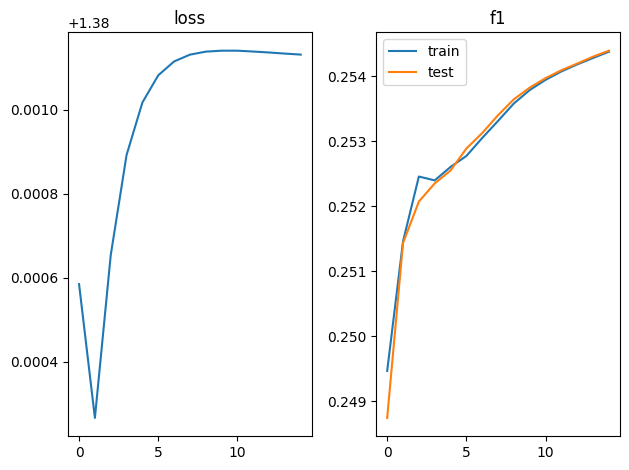

In [26]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(loss_curve)
ax[0].set_title('loss')
ax[1].plot(f1_values_train, label='train')
ax[1].plot(f1_values_test, label='test')
ax[1].set_title('f1')
plt.legend()
plt.tight_layout()

<p class="task" id="4"></p>

4\. Повторите решение задачи 3, создав слой `nn.Embedding` на основе предобученных векторов для слов русского языка и заморозив веса данного слоя. Для поиска векторов можете воспользоваться любым известным вам ресурсом. Сравните качество полученного решения и решения из предыдущей задачи, а также время, затраченное на обучения моделей.  

- [ ] Проверено на семинаре

In [ ]:
!wget "https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/iGqEHyaNh8dXPQ"

In [26]:
import gzip
dct = {}
with gzip.open('iGqEHyaNh8dXPQ', 'rb') as f:
  f.readline()
  for line in f.readlines():
    text = line.decode()
    word, vec = text.split(' ', maxsplit=1)
    word = word.split('_')[0]
    vec = list(map(lambda x: float(x), vec.split()))
    dct[word] = vec

In [27]:
vocab = build_vocab_from_iterator(list(map(lambda x: x[0], list(dct.keys()))), specials=['<PAD>', '<UNK>'])
vocab.set_default_index(vocab['<UNK>'])

In [28]:
train_dataset = NewsDataset(train)
test_dataset = NewsDataset(test)
train_dataset[:3]

(tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 array([1, 3, 1]))

In [29]:
train_loader = DataLoader(train_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [30]:
embeddings = th.tensor(list(dct.values()))
embeddings.shape

torch.Size([318815, 300])

In [31]:
class ModelPretrained(nn.Module):
  def __init__(self):
    super().__init__()
    self.emb = nn.Embedding.from_pretrained(embeddings)
    self.fc1 = nn.Linear(in_features=300, out_features=16)
    self.fc2 = nn.Linear(in_features=16, out_features=len(train_dataset.le.classes_))
    self.relu = nn.ReLU()

  def forward(self, X):
    e = self.emb(X)
    e = e.mean(dim=1)
    out = self.fc1(e)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [34]:
%%time
n_epoch = 15
lr = 0.1
model = ModelPretrained()
model.emb.weight.requires_grad_(False)
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss()
f1 = M.F1Score(task='multiclass', num_classes=len(train_dataset.le.classes_))
loss_curve = []
f1_values_train = []
f1_values_test = []

for epoch in range(n_epoch):
  f1_batch = []
  for X_b, y_b in train_loader:
    out = model(X_b)
    loss = crit(out, th.flatten(y_b))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    f1.update(out.argmax(dim=1), y_b.flatten())
    f1_batch.append(f1.compute().item())
  f1_values_train.append(th.tensor(f1_batch).mean().item())
  loss_curve.append(loss.item())

  f1_batch = []
  for X_b, y_b in test_loader:
    out = model(X_b)
    f1.update(out.argmax(dim=1), y_b.flatten())
    f1_batch.append(f1.compute().item())
  f1_values_test.append(th.tensor(f1_batch).mean().item())
  print(f'{epoch=} loss={loss.item()}')

epoch=0 loss=1.3812158107757568
epoch=1 loss=1.3811981678009033
epoch=2 loss=1.3811699151992798
epoch=3 loss=1.3811531066894531
epoch=4 loss=1.3811423778533936
epoch=5 loss=1.3811349868774414
epoch=6 loss=1.3811298608779907
epoch=7 loss=1.3811256885528564
epoch=8 loss=1.3811227083206177
epoch=9 loss=1.3811205625534058
epoch=10 loss=1.3811187744140625
epoch=11 loss=1.3811171054840088
epoch=12 loss=1.3811159133911133
epoch=13 loss=1.3811149597167969
epoch=14 loss=1.38111412525177
CPU times: user 3min 1s, sys: 3min 17s, total: 6min 19s
Wall time: 6min 22s


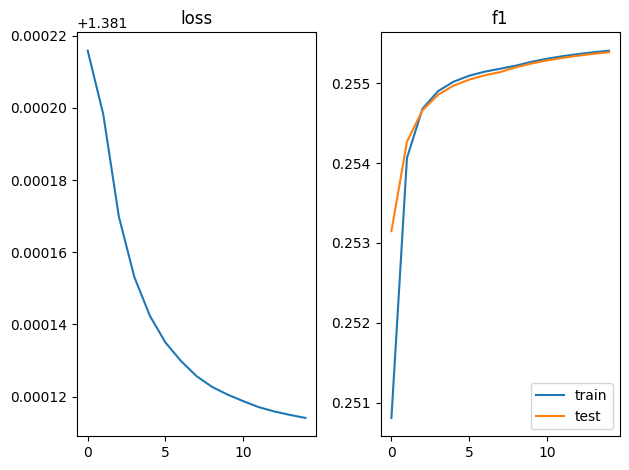

In [35]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(loss_curve)
ax[0].set_title('loss')
ax[1].plot(f1_values_train, label='train')
ax[1].plot(f1_values_test, label='test')
ax[1].set_title('f1')
plt.legend()
plt.tight_layout()

<p class="task" id="5"></p>

5\. Повторите решение задачи 3, не замораживая веса слоя эмбеддингов. Сравните качество полученного решения и решений из предыдущих задач, а также время, затраченное на обучения моделей.  

- [ ] Проверено на семинаре

In [36]:
%%time
n_epoch = 15
lr = 0.1
model = ModelPretrained()
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss()
f1 = M.F1Score(task='multiclass', num_classes=len(train_dataset.le.classes_))
loss_curve = []
f1_values_train = []
f1_values_test = []

for epoch in range(n_epoch):
  f1_batch = []
  for X_b, y_b in train_loader:
    out = model(X_b)
    loss = crit(out, th.flatten(y_b))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    f1.update(out.argmax(dim=1), y_b.flatten())
    f1_batch.append(f1.compute().item())
  f1_values_train.append(th.tensor(f1_batch).mean().item())
  loss_curve.append(loss.item())

  f1_batch = []
  for X_b, y_b in test_loader:
    out = model(X_b)
    f1.update(out.argmax(dim=1), y_b.flatten())
    f1_batch.append(f1.compute().item())
  f1_values_test.append(th.tensor(f1_batch).mean().item())
  print(f'{epoch=} loss={loss.item()}')

epoch=0 loss=1.3813281059265137
epoch=1 loss=1.3811962604522705
epoch=2 loss=1.381160855293274
epoch=3 loss=1.3811441659927368
epoch=4 loss=1.3811345100402832
epoch=5 loss=1.3811285495758057
epoch=6 loss=1.3811242580413818
epoch=7 loss=1.3811213970184326
epoch=8 loss=1.381118893623352
epoch=9 loss=1.381117343902588
epoch=10 loss=1.3811157941818237
epoch=11 loss=1.3811148405075073
epoch=12 loss=1.3811142444610596
epoch=13 loss=1.3811134099960327
epoch=14 loss=1.3811129331588745
CPU times: user 2min 59s, sys: 3min 11s, total: 6min 11s
Wall time: 6min 11s


Затрачено в три раза больше времени на обучение, чем на обучение с замороженными эмбеддингами

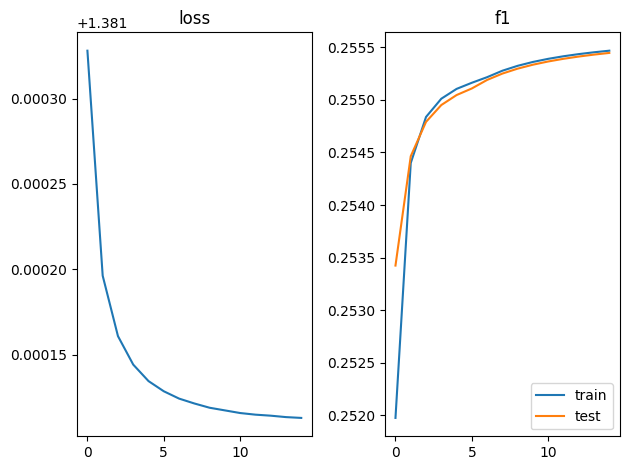

In [37]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(loss_curve)
ax[0].set_title('loss')
ax[1].plot(f1_values_train, label='train')
ax[1].plot(f1_values_test, label='test')
ax[1].set_title('f1')
plt.legend()
plt.tight_layout()

<p class="task" id="6"></p>

6\. Воспользовавшись обученной моделью из предыдущей задачи, визуализируйте эмбеддинги новостей из тестовой выборки в двумерном пространстве. Для проекции точек в двумерное пространство воспользуйтесь алгоритмом t-SNE. Раскрасьте точки в цвет, соответствующий классу новости.

- [ ] Проверено на семинаре

In [38]:
import numpy as np

In [39]:
X_test = test_dataset[:][0]
y_test = test_dataset[:][1]
X_test.shape

torch.Size([4790, 900])

In [40]:
X_emb = model.emb(X_test).mean(dim=1)
X_emb.shape

torch.Size([4790, 300])

In [41]:
from sklearn.manifold import TSNE
X_tsne = TSNE().fit_transform(X_emb)

In [42]:
X_tsne.shape

(4790, 2)

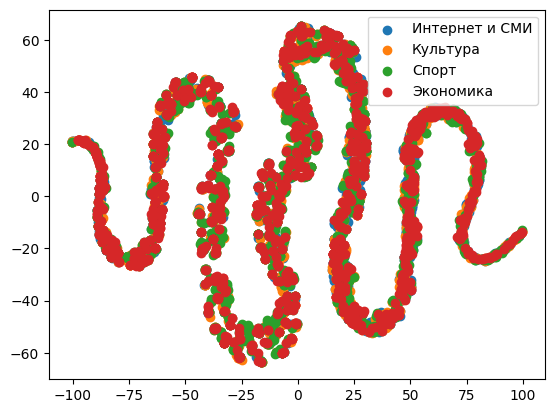

In [43]:
fig, ax = plt.subplots()

for class_ in range(len(train_dataset.le.classes_)):
  ind = np.where(y_test == class_)
  ax.scatter(X_tsne[ind, 0], X_tsne[ind, 1], label=train_dataset.le.classes_[class_])
plt.legend()
plt.show();

## Обратная связь
- [x] Хочу получить обратную связь по решению